# Perfil de una función con Pthreads con Pandas

## Dependencias

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

## Pthreads

Suma de vectores con pthreads.

In [3]:
%%file sumavectpth.c
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>
#include <sys/time.h>

void print_vector(float *v, int size)
{
    printf("\n");
    for (int i = 0; i < size; i++)
    {
        printf("%f\n", v[i]);
    }
    printf("\n");
}

void init_vector(float *v, int size)
{
    for (int i = 0; i < size; i++)
    {
        v[i] = (float)i;
    }
}

double calcularsegundos(struct timeval ti, struct timeval tf)
{
    return (tf.tv_sec - ti.tv_sec) + (tf.tv_usec - ti.tv_usec) / 1000000.0;
}

typedef struct th_info
{
    pthread_t thread;
    int size;
    int id;
    float *v1;
    float *v2;
    float *v3;
} th_info;

void *pth_func(void *args)
{
    th_info *th_info_args = (th_info *)args;
    for (int i = 0; i < th_info_args->size; i++)
    {
        th_info_args->v3[i] = th_info_args->v1[i] + th_info_args->v2[i];
    }
    return NULL;
}

void parallel_vector_sum(float *v1, float *v2, float *v3, int tam, int ths)
{
    int size = (tam / ths);

    th_info threads[ths];

    for (int i = 0; i < ths; i++)
    {
        threads[i].size = size;
        threads[i].id = i;
        threads[i].v1 = v1 + i * size;
        threads[i].v2 = v2 + i * size;
        threads[i].v3 = v3 + i * size;
    }

    pth_func((void *)&threads[0]);

    if (ths > 1)
    {
        for (size_t i = 1; i < ths; ++i)
        {
            pthread_create(&threads[i].thread, NULL, pth_func, (void *)&threads[i]);
        }

        for (size_t i = 1; i < ths; ++i)
        {
            pthread_join(threads[i].thread, NULL);
        }
    }
}

int main(int argc, char **argv)
{
    if (argc != 3)
    {
        printf("Usage: %s <tam> <ths>\n", argv[0]);
        exit(-1);
    }

    struct timeval ti, tf;

    int tam = atoi(argv[1]);

    int ths = atoi(argv[2]);

    float *v1 = (float *)malloc(tam * sizeof(float));
    float *v2 = (float *)malloc(tam * sizeof(float));
    float *v3 = (float *)malloc(tam * sizeof(float));

    // init vectores
    init_vector(v1, tam);
    init_vector(v2, tam);

    gettimeofday(&ti, NULL);
    parallel_vector_sum(v1, v2, v3, tam, ths);
    gettimeofday(&tf, NULL);

    double segundos = calcularsegundos(ti, tf);
    printf("%s,%s,%lf\n",argv[1],argv[2],segundos);

    free(v1);
    free(v2);
    free(v3);

    return 0;
}

Writing sumavectpth.c


In [4]:
! gcc sumavectpth.c -o sumavectpth -pthread 

In [5]:
! ./sumavectpth

Usage: ./sumavectpth <tam> <ths>


Archivo de bash que servirá para hacer las pruebas y registrar los resultados en archivos de valores separados por comas

In [6]:
%%file perfil.sh

printf "n,ths,tiempo\n" > perfil.csv

for n in 5000000 10000000 50000000 100000000
do
    for th in 1 2 3 4 6 8
    do
        for i in {1..20}
        do
          ./sumavectpth $n $th >> perfil.csv
        done
    done
done

Writing perfil.sh


Se ejecuta el archivo de bash

In [7]:
! bash perfil.sh

Leer el archivo CSV

In [8]:
perfil = pd.read_csv('perfil.csv',delimiter=',')

In [9]:
perfil

,n,ths,tiempo
0,5000000,1,0.017525
1,5000000,1,0.017414
2,5000000,1,0.017411
3,5000000,1,0.017359
4,5000000,1,0.017231
...,...,...,...
475,100000000,8,0.214148
476,100000000,8,0.213856
477,100000000,8,0.231730
478,100000000,8,0.227134


Obtener la columna de tamagnos y eliminar los valores repetidos

In [10]:
ns = perfil['n'].drop_duplicates().to_numpy()
ns

array([  5000000,  10000000,  50000000, 100000000])

Obtener la columna de la cantidad de threads y eliminar los valores repetidos

In [11]:
ths = perfil['ths'].drop_duplicates().to_numpy()
ths

array([1, 2, 3, 4, 6, 8])

Gráfica que muestra como varía el tiempo promedio para cada tamagno, de acuerdo al número de threads, luego de realizar una mediana desplazante de ventana 7. 

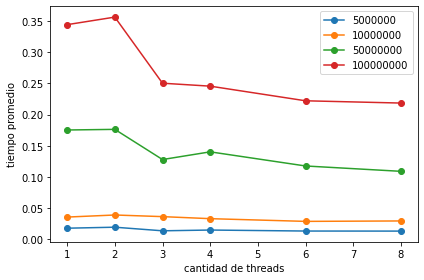

In [12]:
for n in ns:
    tn = []
    for th in ths:
        tn.append(perfil[(perfil['n'] == n) & (perfil['ths'] == th)]['tiempo'].rolling(7,min_periods=1).median().mean())
    plt.plot(ths,tn,'-o',label=str(n))
    plt.legend()
plt.xlabel('cantidad de threads')
plt.ylabel('tiempo promedio')
plt.tight_layout()

Subgráficos para observar con más detalle como es la variación del tiempo en cada tamagno

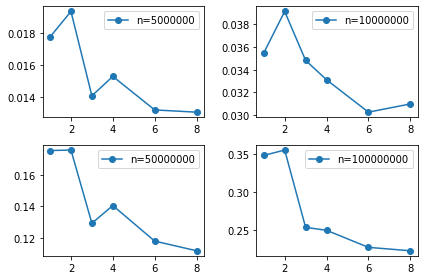

In [14]:
r = 2
c = 2
for i in range(r):
    for j in range(c):
        ind = i*r+j
        plt.subplot(r,c,ind+1)
        ts = perfil[perfil['n'] == ns[ind]].groupby('ths').mean()['tiempo'].to_numpy()
        plt.plot(ths,ts,'-o',label='n='+str(ns[ind]))
        plt.legend()
plt.tight_layout()

En las gráficas anteriores se observa para los cuatro tamagnos, que el mayor tiempo no ocurrió necesariamente cuando se usó un solo _thread_. Sin embargo, el tiempo con un solo _thread_ será la referencia para calcular el _speedup_.

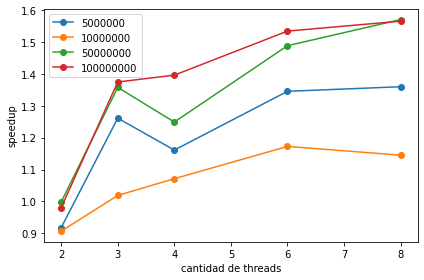

In [15]:
for n in ns:
    ts = perfil[perfil['n'] == n].groupby('ths').mean()['tiempo'].to_numpy()
    plt.plot(ths[1:],ts[0]/ts[1:],'-o',label=str(n))
plt.legend()
plt.xlabel('cantidad de threads')
plt.ylabel('speedup')
plt.tight_layout()

In [16]:
! rm *.c
! rm *.sh